<div align=center>
		
<font size=5>
In the Name of God
<font/>
<p></p>
<br/>
<br/>
<font color=#FF7500>
Sharif University of Technology - Departmenet of Computer Engineering
</font>
<p></p>
<font color=blue>
Artifical Intelligence - Dr. Mahdieh Soleimani
</font>
<br/>
<br/>
Fall 2022

<hr/>
<font color=red>
Reinforcment Learning Practical Assignment
</font>
</div>

<ul>
  <li>Some cell's outputs have not been deleted. you can use these to make sure your implementation is correct.</li>
</ul>

In this notebook you will use the [openai gym](https://www.gymlibrary.dev/) library to train agents in two different reinforcment learning environments. the first environment is a very simple grid-world with discrete states. The second environment however, has continous states.  
make sure to upload your model performance video alongside this notebook. We suggest running this notebook on google colab so that you wont face any package errors.

we will first install the necessary packages.

In [ ]:
!pip install gym==0.26
!pip install imageio imageio_ffmpeg
!pip install pygame
!pip install pyglet==1.5.1 
!apt install python-opengl
!apt install ffmpeg
!apt install xvfb
!pip3 install pyvirtualdisplay

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 710 kB 5.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gym: filename=gym-0.26.0-py3-none-any.whl size=826304 sha256=2cd814a96d414af62e5d160442895029ceaafac04b3d07a7dd8531f0424cf322
  Stored in directory: /root/.cache/pip/wheels/f1/f2/92/63d51de23bd3ef89d87af5663ef0a1b04781ccb9757b6f98d4
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 26.9 MB 2.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 21.

the functions below will be used to make a video of the model performance. It will start the environment and choose the best action based on the given Qtable.

In [145]:
from IPython.display import HTML
from base64 import b64encode
import imageio

## comment this part if your not using google colab
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()
######################

def record_video_frozen_lake_env(env, Qtable, out_directory, fps=1, random_action=False):
  images = []  
  done = False
  state, info = env.reset(seed=random.randint(0,500))
  img = env.render()
  images.append(img)
  while not done:
    # Take the action (index) that have the maximum expected future reward given that state
    action = np.random.randint(4)  if random_action else np.argmax(Qtable[state][:])
    state, reward, done, truncated, info = env.step(action)
    img = env.render()
    images.append(img)
  imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)

def show_video(video_path, video_width = 600):
  video_file = open(video_path, "r+b").read()
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

## Part I: FrozenLake Environment (35 + 10 Points)

In [146]:
import numpy as np
import gym
import random
from tqdm.notebook import tqdm

In this exercise, we want to solve the FrozenLake environment. It is a simple grid-world environment where we have to reach a goal state while avoiding holes.  
You can read more about this environment [here](https://www.gymlibrary.dev/environments/toy_text/frozen_lake/)

**[Question 1 (1 Points)]**  
Create a <u>slippery</u> FrozenLake environment of size <u>4x4</u>

In [147]:
env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=True, render_mode='rgb_array')

Let's run a random policy in this environement to get a better understanding of it.

In [148]:
record_video_frozen_lake_env(env, None, 'frozenlake_random.mp4', fps=1, random_action=True)
show_video('frozenlake_random.mp4', video_width = 600)

**[Question 2 (1 Points)]**  
Briefly describe the state space, action space, and reward function of this environment.

**Answer:**  
state space: 16 tiles as states(current_row * nrows + current_col). 

action space: 4 possible actions 'Left', 'Right', 'Up', and 'Down'. 

reward function: 
     Reach goal(G): +1
     .Reach hole(H): 0
     .Reach frozen(F): 0


**[Question 3 (2 Points)]**  
Complete the code for `initialize_q_table` function. It should create a Q-table of size (state_space, action_space) and initializes it. You are free to use whichever initialization you want (a good starting point is to initialize it with all zeros)

In [149]:
def initialize_q_table(state_space, action_space):
  Qtable = np.zeros((state_space, action_space))
  return Qtable

In [150]:
Qtable = initialize_q_table(env.observation_space.n, env.action_space.n)

**[Question 4 (2 Points)]**  
Complete the code for `epsilon_greedy_policy` function. It should select the best action according to the current Q-function with probability $1-\varepsilon$ and select a random action with probability $\varepsilon$.

In [151]:
def epsilon_greedy_policy(Qtable, state, epsilon):
  if np.random.random() <= epsilon:
    action = np.random.randint(4)
  else:
    action = np.argmax(Qtable[state, :])
  return action

**[Question 5 (4 Points)]**  
You need to choose appropriate hyperparameters for the agent to learn.

In particular, you must find a suitable learning rate and exploration parameters. To facilitate exploration, a common practice is to start with a high exploration rate ($\varepsilon$) and gradually decrease it as the agent gets better. To implement this, you need to specify the starting exploration rate (`max_epsilon`), the final exploration rate (`min_epsilon`) and a decay rate which reduces the exploration rate after each update (see the `train` function below).

In [152]:
# Training parameters
n_training_episodes = 50_000  # Total training episodes
n_eval_episodes = 10_000
learning_rate = 0.1        # Learning rate

# Environment parameters
max_steps = 99               # Max steps per episode
gamma = 0.95                 # Discounting rate

# Exploration parameters
max_epsilon = 1           # Exploration probability at start
min_epsilon = 0.01           # Minimum exploration probability 
decay_rate = 0.01            # Exponential decay rate for exploration prob
current_epsilon = 0.0

**[Question 6 (10 Points)]**  
Complete the `train` function which updates `Qtable` using the Q-learning update rule.

In [153]:
def train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable):
  rewards = []
  for episode in tqdm(range(n_training_episodes)):
    # Adjust epsilon
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
    # Reset the environment
    state, info = env.reset()
    step = 0
    done = False
    sum_rewards = 0
    # repeat
    for step in range(max_steps):
      # You must:
      # Take action A_t and observe R_{t+1}, S_{t+1}
      # Update the Qtable with (S_t, A_t, R_{t+1}, S_{t+1})
      # Be careful about episode termination and truncation
      action = epsilon_greedy_policy(Qtable, state, epsilon)
      info = env.step(action)
      new_state = info[0]
      reward = info[1]
      done = info[2]
      Qtable[state, action] = Qtable[state, action] + learning_rate * (reward + gamma * np.max(Qtable[new_state]) - Qtable[state, action])
      state = new_state
      sum_rewards += reward
      if done:
        break
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * (episode + 1))
    rewards.append(sum_rewards)
  current_epsilon = epsilon  
  return Qtable

We are now ready to train our agent.

In [ ]:
Qtable_trained = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable)

  0%|          | 0/50000 [00:00<?, ?it/s]

Now, we will evaluate our agent. You don't need to write any code, just run the following cells as they are.

In [ ]:
def evaluate_agent(env, max_steps, n_eval_episodes, Q):
  """
  Evaluate the agent for ``n_eval_episodes`` episodes and returns average reward and std of reward.
  :param env: The evaluation environment
  :param n_eval_episodes: Number of episode to evaluate the agent
  :param Q: The Q-table
  """
  episode_rewards = []
  for episode in tqdm(range(n_eval_episodes)):
    state, info = env.reset()
    step = 0
    terminated = False
    total_rewards_ep = 0
    
    for step in range(max_steps):
      action = np.argmax(Q[state][:])
      new_state, reward, terminated, truncated, info = env.step(action)
      total_rewards_ep += reward
        
      if terminated:
        break
      state = new_state
    episode_rewards.append(total_rewards_ep)
  mean_reward = np.mean(episode_rewards)
  std_reward = np.std(episode_rewards)

  return mean_reward, std_reward

In [ ]:
mean_reward, std_reward = evaluate_agent(env, max_steps, n_eval_episodes, Qtable_trained)
print(f"Mean_reward={mean_reward:.2f} +/- {std_reward:.2f}") # should be around 0.65

  0%|          | 0/10000 [00:00<?, ?it/s]

Mean_reward=0.73 +/- 0.45


Now let's see how well our model is doing.

In [ ]:
record_video_frozen_lake_env(env, Qtable_trained, 'frozenlake_trained.mp4', fps=1)
show_video('frozenlake_trained.mp4', video_width = 600)

Next, we will take a look at the Q-function that was learned.

In [ ]:
print(Qtable_trained)

[[0.19051201 0.15144325 0.16436651 0.16028029]
 [0.05470778 0.0838057  0.09122568 0.17921634]
 [0.16923369 0.09124934 0.08581535 0.08589674]
 [0.07048271 0.07103991 0.06970598 0.08055696]
 [0.2117109  0.18997573 0.14209041 0.12233322]
 [0.         0.         0.         0.        ]
 [0.06523151 0.06580946 0.22287718 0.05392891]
 [0.         0.         0.         0.        ]
 [0.18166351 0.15955822 0.18650292 0.2703529 ]
 [0.30674816 0.38372437 0.24821351 0.14419867]
 [0.31593684 0.19767626 0.19920494 0.18437323]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.25128838 0.33804343 0.51488505 0.28952286]
 [0.47622579 0.787432   0.49283249 0.48316578]
 [0.         0.         0.         0.        ]]


**[Question 7 (5 Points)]**  
Assume that `Qtable_trained` is the correct Q-function for the final epsilon-greedy policy that was used in training. What is the value function that corresponds to this policy? Write down the relation between $V_\pi$ and $Q_\pi$ and use it to complete the following code block.

**Answer:**
$$V_\pi (s) = Q_\pi (s,\pi(s)) $$

In [ ]:
Vtable_trained = [Qtable_trained[i,epsilon_greedy_policy(Qtable_trained, i, current_epsilon)] for i in range(len(Qtable_trained))]

Take a look at the value function

In [ ]:
print(Vtable_trained)

[0.19051201270294177, 0.1792163372360861, 0.1692336856673049, 0.0805569573783276, 0.21171090127847703, 0.0, 0.2228771842780802, 0.0, 0.2703529002393518, 0.38372437040937835, 0.3159368365432915, 0.0, 0.0, 0.5148850511226493, 0.7874320014894183, 0.0]


**[Question 8 (5 Points)]**  
Write a function to generate a visualization for the value function using a heatmap. In a few words, explain what you see.

In [ ]:
import seaborn as sns
import pandas as pd
def visualize(Vtable):
  df = pd.DataFrame(np.array(Vtable_trained).reshape(4,4))
  sns.heatmap(df, annot=True, cmap = 'RdPu')

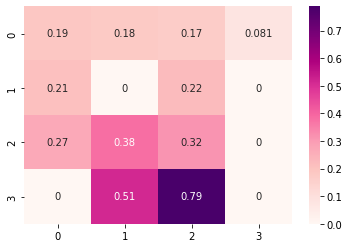

In [ ]:
visualize(Vtable_trained)

**[Question 9 (5 Points)]**  
Can we use a pure greedy policy for Q-learning? Explain.

**Answer:**

No. Because there won't be any exploration and therefore no learning would happen and would only converge to the optimal policy.

**[Bonus Question (10 Points)]**  
Think about the role of the discount factor in this environment and experiment.  
1. Explain why it is not the best idea to set $\gamma = 1$ for a navigation task. You might find it easier to reason about a deterministic (i.e., non-slippery) environment. (5 Points)


**Answer:**
1. because by not being threatened to lose something, the model would just keep moving around forever as long as it's not losing. Therefore, the computation cost and running time would be extremely high because the model is not urgently searching for the goal since it knows that no matter when it reaches the goal, the reward is the same.
